# Building a Model to Predict Employee Turnover

## Contents
1. Problem Statement
2. Data Analysis
3. Pre-Processing Pipeline
4. Building Machine Learning Models
5. Conclusion

## 1. Problem Statement

Employee turnover/attrition creates numerous disadvantages for an organization.  
A study by Forbes stated that employee turnover can cost 50%, 120% and 200% of the salary for entry, mid-level, and senior levels.    
In 2018, the total loss was estimated to be $14.3 million on employee turnovers.  
(https://www.forbes.com/sites/billconerly/2018/08/12/companies-need-to-know-the-dollar-cost-of-employee-turnover/#2065dcdbd590)   
In addition to the monetary loss, organizations lose valuable time and resources attempting to reskill, rehire, or retain employees.   
This phenomenom has caused organization to examine qualitative inititatives (e.g. employee engagement) as well as quantitative (retention offers, sign-on bonuses, raises).   
In this project, we attempt to predict employee attrition to better aid organizations in strategically preparing for changes to the workforce.

## 2. Data Analysis

### 2.1 Data Description and Source

Data can be accessed via (https://archive.org/download/opm-federal-employment-data)  
For this project, we will focus on the most recent data file that contains both attrition and status records for Non-DoD employees.  
Non-DoD records were chosen as a preference in having previously held a Federal position under DHHS.  
Given the dataset options; we will focus on Q3 (June-September) of 2016.  

Attrition data provides information on separations that occured in our selected time period.  
Status data provides us information on the current workforce during our selected time period.  

Attrition data: https://ia800608.us.archive.org/16/items/opm-federal-employment-data/data/2014-09-to-2016-09/non-dod/separations/Separations%20Non_DoD%20FY2016Q3.txt  
Status data: https://ia800608.us.archive.org/16/items/opm-federal-employment-data/data/2014-09-to-2016-09/non-dod/status/Non_DoD_201606.txt  

Data translation: https://archive.org/download/opm-federal-employment-data/data/2014-09-to-2016-09/non-dod/translations/

### 2.2 Data Wrangling/Exploration

In [3]:
import pandas as pd #for dataframes
import matplotlib.pyplot as plt #for plotting graphs
import seaborn as sns #for plotting graphs
from scipy.stats import norm, skew
from scipy import stats
import numpy as np

import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

In [4]:
# load data for attritions in Q3 of 2016
attrition_data = pd.read_csv('Separations Non_DoD FY2016Q3.txt', sep = '|', header = None, names=['LastName', 'FirstName', 'DateFiled', 'Agency', 'SubAgency', 'SeparationCode', 
                     'DutyStation', 'AgeRange', 'YearsSinceDegree', 'EducationLevel', 'PayPlan', 'Grade',
                     'LengthofService', 'Occupation', 'OccupationalCategory', 'AdjustedBasicPay', 
                    'SupervisoryStatus', 'TypeofAppointment', 'WorkSchedule', 'NSFTPIND'])

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
attrition_data.head()

,LastName,FirstName,DateFiled,Agency,SubAgency,SeparationCode,DutyStation,AgeRange,YearsSinceDegree,EducationLevel,PayPlan,Grade,LengthofService,Occupation,OccupationalCategory,AdjustedBasicPay,SupervisoryStatus,TypeofAppointment,WorkSchedule,NSFTPIND
0,MORGAN,MILLETT,20160419,EP-ENVIRONMENTAL PROTECTION AGENCY,EP00-ENVIRONMENTAL PROTECTION AGENCY,SJ,42,65 or more,45 - 49 years,21,EF,00,10 - 14 years,1301-GENERAL PHYSICAL SCIENCE,P,110256.21,48,I,2,NaN
1,BLODGETT,JEFFREY,20160422,CM-DEPARTMENT OF COMMERCE,CM63-U.S. CENSUS BUREAU,SC,33,65 or more,Unspecified,04,GG,03,Less than 1 year,0303-MISCELLANEOUS CLERK AND ASSISTANT,C,25731.00,40,I,2,NaN
2,WHOLEY,GAIL,20160430,HU-DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT,HU01-OFFICE OF THE SENIOR COORDINATOR FOR NEW ...,SD,25,60-64,35 - 39 years,18,GS,13,30 - 34 years,1101-GENERAL BUSINESS AND INDUSTRY,A,120187.00,10,F,1,NaN
3,NAME WITHHELD BY OPM,NAME WITHHELD BY OPM,20160531,HS-DEPARTMENT OF HOMELAND SECURITY,HSBC-TRANSPORTATION SECURITY ADMINISTRATION,SD,##,65 or more,Unspecified,04,SV,E,15 - 19 years,1802-COMPLIANCE INSPECTION AND SUPPORT,T,41339.00,38,F,1,NaN
4,RYER,JEANNE,20160515,HE-DEPARTMENT OF HEALTH AND HUMAN SERVICES,HE70-CENTERS FOR MEDICARE & MEDICAID SERVICES,SJ,24,60-64,20 - 24 years,17,EH,00,1 - 2 years,0301-MISCELLANEOUS ADMINISTRATION AND PROGRAM,A,65218.75,48,I,2,NaN


In [6]:
#focus on General Schedule (GS) Pay Plan
GS_data = attrition_data[attrition_data.PayPlan == 'GS']
GS_data = pd.DataFrame(GS_data)
GS_data.to_csv('attrition.csv')

Text(0.5, 1.0, 'Frequency of Employee Attrition Q4 of 2014')

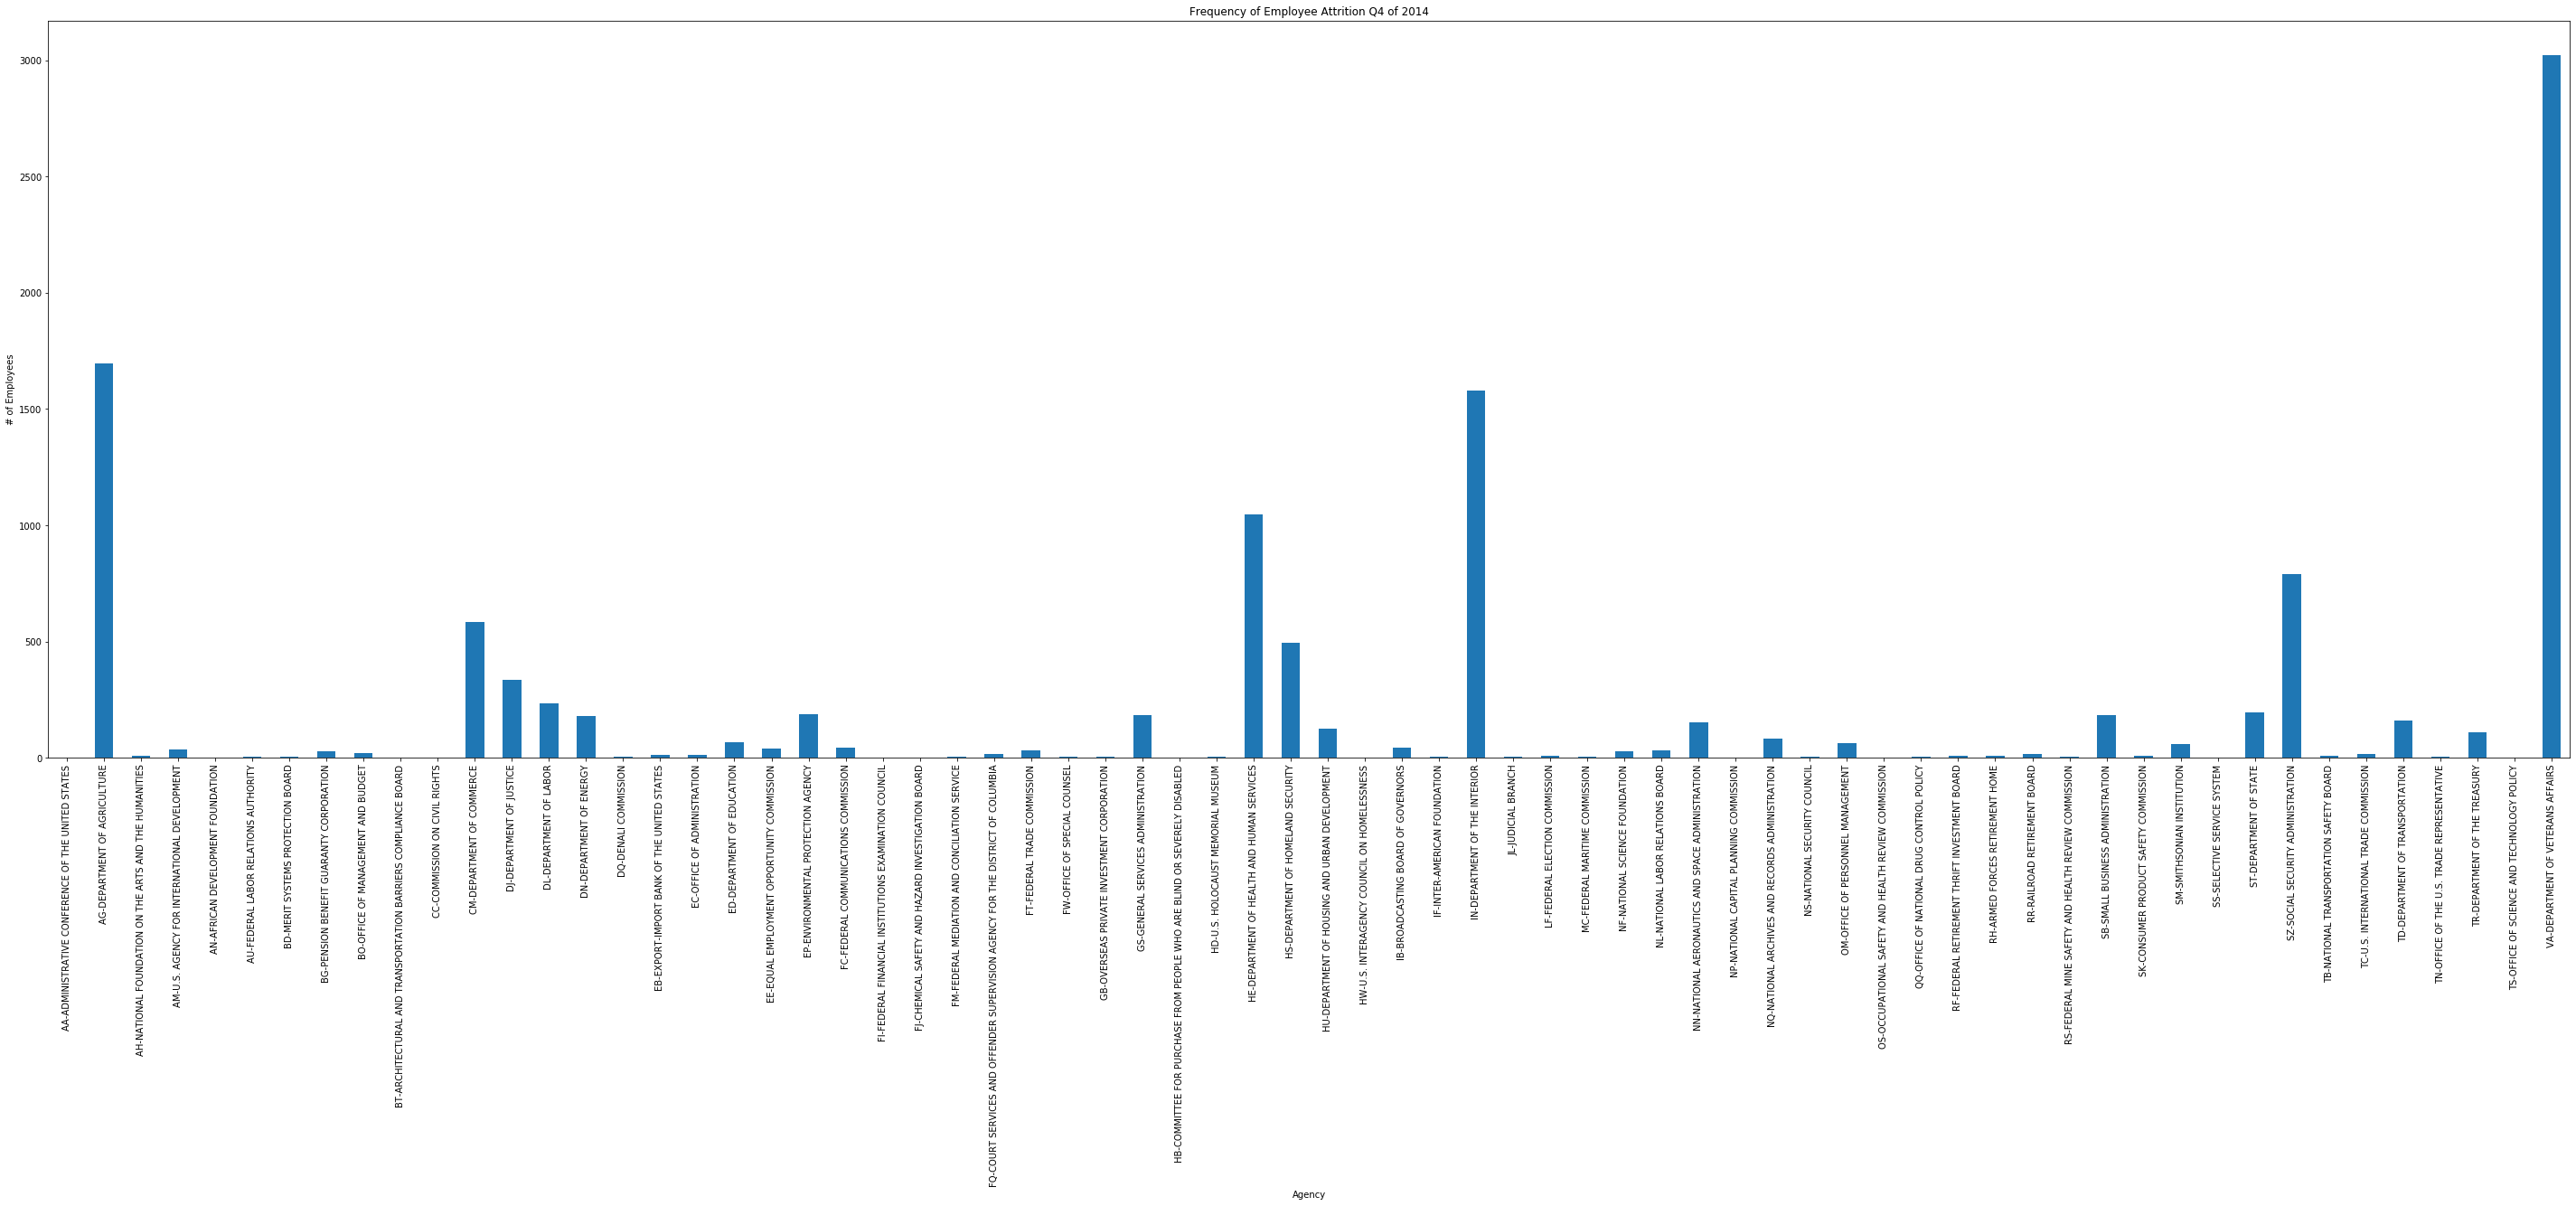

In [7]:
#plot the number of attritions by agency
freq = plt.figure(figsize=(50,15))
ax1 = freq.add_subplot(111)
GS_data.groupby('Agency').agg({'LastName':'nunique'}).plot(kind='bar', ax=ax1, legend=False)
ax1.set_xlabel('Agency')
ax1.set_ylabel('# of Employees')
ax1.set_title('Frequency of Employee Attrition Q4 of 2014')

### In order define the scope of our project, we decided to focus on the agency with the highest attrition -  
### Department of Verterans Affairs

In [12]:
#focus on one agency to dive deep into analysis
#we pick the department of veterans affairs since it shows the highest attrition rate for Q3 in 2016

VA_data = GS_data[GS_data.Agency == 'VA-DEPARTMENT OF VETERANS AFFAIRS']
VA_data.shape

(4946, 20)

In [13]:
VA_data.head()

,LastName,FirstName,DateFiled,Agency,SubAgency,SeparationCode,DutyStation,AgeRange,YearsSinceDegree,EducationLevel,PayPlan,Grade,LengthofService,Occupation,OccupationalCategory,AdjustedBasicPay,SupervisoryStatus,TypeofAppointment,WorkSchedule,NSFTPIND
10,NAME WITHHELD BY OPM,NAME WITHHELD BY OPM,20160416,VA-DEPARTMENT OF VETERANS AFFAIRS,VALA-VETERANS BENEFITS ADMINISTRATION,SC,##,55-59,10 - 14 years,13,GS,11,10 - 14 years,"1801-GENERAL INSPECTION, INVESTIGATION, ENFORC...",A,73510.00,10,F,1,NaN
19,MOULTON,DANIEL,20160402,VA-DEPARTMENT OF VETERANS AFFAIRS,VATA-VETERANS HEALTH ADMINISTRATION,SA,11,30-34,5 - 9 years,17,GS,13,3 - 4 years,0301-MISCELLANEOUS ADMINISTRATION AND PROGRAM,A,92145.00,10,F,1,NaN
25,NAME WITHHELD BY AGENCY,NAME WITHHELD BY AGENCY,20160625,VA-DEPARTMENT OF VETERANS AFFAIRS,VATA-VETERANS HEALTH ADMINISTRATION,SA,##,40-44,10 - 14 years,17,GS,11,3 - 4 years,0101-SOCIAL SCIENCE,P,71348.00,38,F,1,NaN
48,STANCIL,CHERYL,20160513,VA-DEPARTMENT OF VETERANS AFFAIRS,VATA-VETERANS HEALTH ADMINISTRATION,SC,50,50-54,Unspecified,04,GS,05,5 - 9 years,0303-MISCELLANEOUS CLERK AND ASSISTANT,C,42012.00,10,F,1,NaN
52,BENKO,MATTHEW,20160401,VA-DEPARTMENT OF VETERANS AFFAIRS,VATA-VETERANS HEALTH ADMINISTRATION,SC,42,35-39,5 - 9 years,17,GS,11,5 - 9 years,0101-SOCIAL SCIENCE,P,.,10,F,1,NaN


In [14]:
#load data for current employees for Q3 of 2016
status_data = pd.read_csv('Non_DoD_201609.txt', sep = '|', header = None, names=['LastName', 'FirstName', 'DateFiled', 'Agency', 'SubAgency', 'State', 
                    'AgeRange', 'YearsSinceDegree', 'EducationLevel', 'PayPlan', 'Grade',
                     'LengthofService', 'Occupation', 'OccupationalCategory', 'AdjustedBasicPay', 
                    'SupervisoryStatus', 'TypeofAppointment', 'WorkSchedule', 'NSFTPIND'])

In [15]:
#again, we will focus on VA-Veterans Affairs records and GS pay schedules
VA_status = status_data[status_data.Agency == 'VA-DEPARTMENT OF VETERANS AFFAIRS']
VA_status = VA_status[VA_status.PayPlan == 'GS']
VA_status.shape

(233457, 19)

In [16]:
#set index as 'Agency' VA_data.set_index('Agency', inplace = True) VA_status.set_index('Agency', inplace=True)
#add code for current employee (0) and employee that left (1)
VA_data.loc[:,'Attrition'] = 'Yes'

In [17]:
VA_status.loc[:,'Attrition'] = 'No'

In [18]:
#focus on columns we want

cols = ['SubAgency',
       'AgeRange',
       'PayPlan',
       'Grade',
       'LengthofService',
       'Occupation',
       'AdjustedBasicPay',
       'Attrition']
VA_data = VA_data[cols]
VA_data.head()

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
10,VALA-VETERANS BENEFITS ADMINISTRATION,55-59,GS,11,10 - 14 years,"1801-GENERAL INSPECTION, INVESTIGATION, ENFORC...",73510.00,Yes
19,VATA-VETERANS HEALTH ADMINISTRATION,30-34,GS,13,3 - 4 years,0301-MISCELLANEOUS ADMINISTRATION AND PROGRAM,92145.00,Yes
25,VATA-VETERANS HEALTH ADMINISTRATION,40-44,GS,11,3 - 4 years,0101-SOCIAL SCIENCE,71348.00,Yes
48,VATA-VETERANS HEALTH ADMINISTRATION,50-54,GS,05,5 - 9 years,0303-MISCELLANEOUS CLERK AND ASSISTANT,42012.00,Yes
52,VATA-VETERANS HEALTH ADMINISTRATION,35-39,GS,11,5 - 9 years,0101-SOCIAL SCIENCE,.,Yes


In [19]:
cols = ['SubAgency',
       'AgeRange',
       'PayPlan',
       'Grade',
       'LengthofService',
       'Occupation',
       'AdjustedBasicPay',
       'Attrition']
VA_status = VA_status[cols]
VA_status.head()

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
5,VATA-VETERANS HEALTH ADMINISTRATION,45-49,GS,06,3 - 4 years,0681-DENTAL ASSISTANT,46012.00,No
21,VATA-VETERANS HEALTH ADMINISTRATION,65 or more,GS,13,10 - 14 years,0184-SOCIOLOGY,110328.00,No
29,VATA-VETERANS HEALTH ADMINISTRATION,65 or more,GS,09,15 - 19 years,1654-PRINTING SERVICES,60391.00,No
40,VATA-VETERANS HEALTH ADMINISTRATION,65 or more,GS,13,10 - 14 years,0671-HEALTH SYSTEM SPECIALIST,120187.00,No
42,VALA-VETERANS BENEFITS ADMINISTRATION,60-64,GS,10,5 - 9 years,0996-VETERANS CLAIMS EXAMINING,53925.00,No


In [20]:
VA_employee = pd.merge(VA_data, VA_status, how='outer')
VA_employee.shape

(238403, 8)

In [21]:
#look at the data types in our merged table
VA_employee.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238403 entries, 0 to 238402
Data columns (total 8 columns):
SubAgency           238403 non-null object
AgeRange            238403 non-null object
PayPlan             238403 non-null object
Grade               238403 non-null object
LengthofService     238403 non-null object
Occupation          238403 non-null object
AdjustedBasicPay    238403 non-null object
Attrition           238403 non-null object
dtypes: object(8)
memory usage: 16.4+ MB


In [22]:
#examine the percentage of missing values in each column
missing = VA_employee.isna().mean().round(4) * 100
missing

SubAgency           0.0
AgeRange            0.0
PayPlan             0.0
Grade               0.0
LengthofService     0.0
Occupation          0.0
AdjustedBasicPay    0.0
Attrition           0.0
dtype: float64

### The attrition rate for Q4 of 2014 was 2.19%

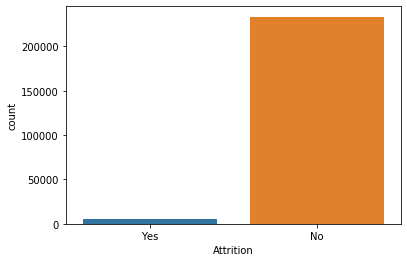

In [23]:
sns.countplot(VA_employee['Attrition'])

In [24]:
VA_employee.Attrition.value_counts()

No     233457
Yes      4946
Name: Attrition, dtype: int64

### The average age of current and past employees are fairly similar (45.6 yrs and 44.7 yrs respectively)
### Since these ages are ranges, we will assume that they are equal

In [25]:
VA_employee['AgeRange'].value_counts()

50-54           36589
55-59           33848
45-49           33795
35-39           30120
40-44           27806
30-34           27009
60-64           23444
25-29           12766
65 or more      10504
20-24            2425
Less than 20       97
Name: AgeRange, dtype: int64

In [26]:
VA_employee['AgeRange'].astype(str)

0         55-59
1         30-34
2         40-44
3         50-54
4         35-39
          ...  
238398    45-49
238399    30-34
238400    35-39
238401    25-29
238402    25-29
Name: AgeRange, Length: 238403, dtype: object

In [27]:
VA_employee['AgeRange'] = VA_employee['AgeRange'].map({'65 or more': 65, '60-64': 60, '55-59': 55, '50-54':50, '45-49':45,
                                                      '40-44':40, '35-39':35, '30-34':30, '25-29':25, '20-24':20, 'Less than 20':15})

In [28]:
VA_employee['AgeRange'].astype(int)

0         55
1         30
2         40
3         50
4         35
          ..
238398    45
238399    30
238400    35
238401    25
238402    25
Name: AgeRange, Length: 238403, dtype: int64

In [29]:
(mu, sigma) = norm.fit(VA_employee.loc[VA_employee['Attrition'] == 'Yes', 'AgeRange'])
print(
    'Ex-exmployees: average age = {:.1f} years old and standard deviation = {:.1f}'.format(mu, sigma))
(mu, sigma) = norm.fit(VA_employee.loc[VA_employee['Attrition'] == 'No', 'AgeRange'])
print('Current exmployees: average age = {:.1f} years old and standard deviation = {:.1f}'.format(
    mu, sigma))

Ex-exmployees: average age = 45.6 years old and standard deviation = 13.7
Current exmployees: average age = 44.6 years old and standard deviation = 11.2


### Veterans Health Administration holds a significant majority of employees within the VA

In [30]:
VA_employee['SubAgency'].value_counts()

VATA-VETERANS HEALTH ADMINISTRATION                                                            201164
VALA-VETERANS BENEFITS ADMINISTRATION                                                           22471
VAEB-DEPUTY ASSISTANT SECRETARY FOR INFORMATION AND TECHNOLOGY                                   7951
VADG-DEPUTY ASSISTANT SECRETARY FOR ACQUISTION AND LOGISTICS                                     1083
VAPA-NATIONAL CEMETERY ADMINISTRATION                                                             882
VADD-DEPUTY ASSISTANT SECRETARY FOR FINANCE                                                       879
VAAF-INSPECTOR GENERAL                                                                            709
VAAE-GENERAL COUNSEL                                                                              708
VAAD-BOARD OF VETERANS APPEALS                                                                    616
VAAA-OFFICE OF THE SECRETARY                                                      

### Several of the SubAgencies show similar attrition rates. The highest is the VABA - Immediate Office of the Assisstant Secretary for Human Resources and Administration with over 8%.

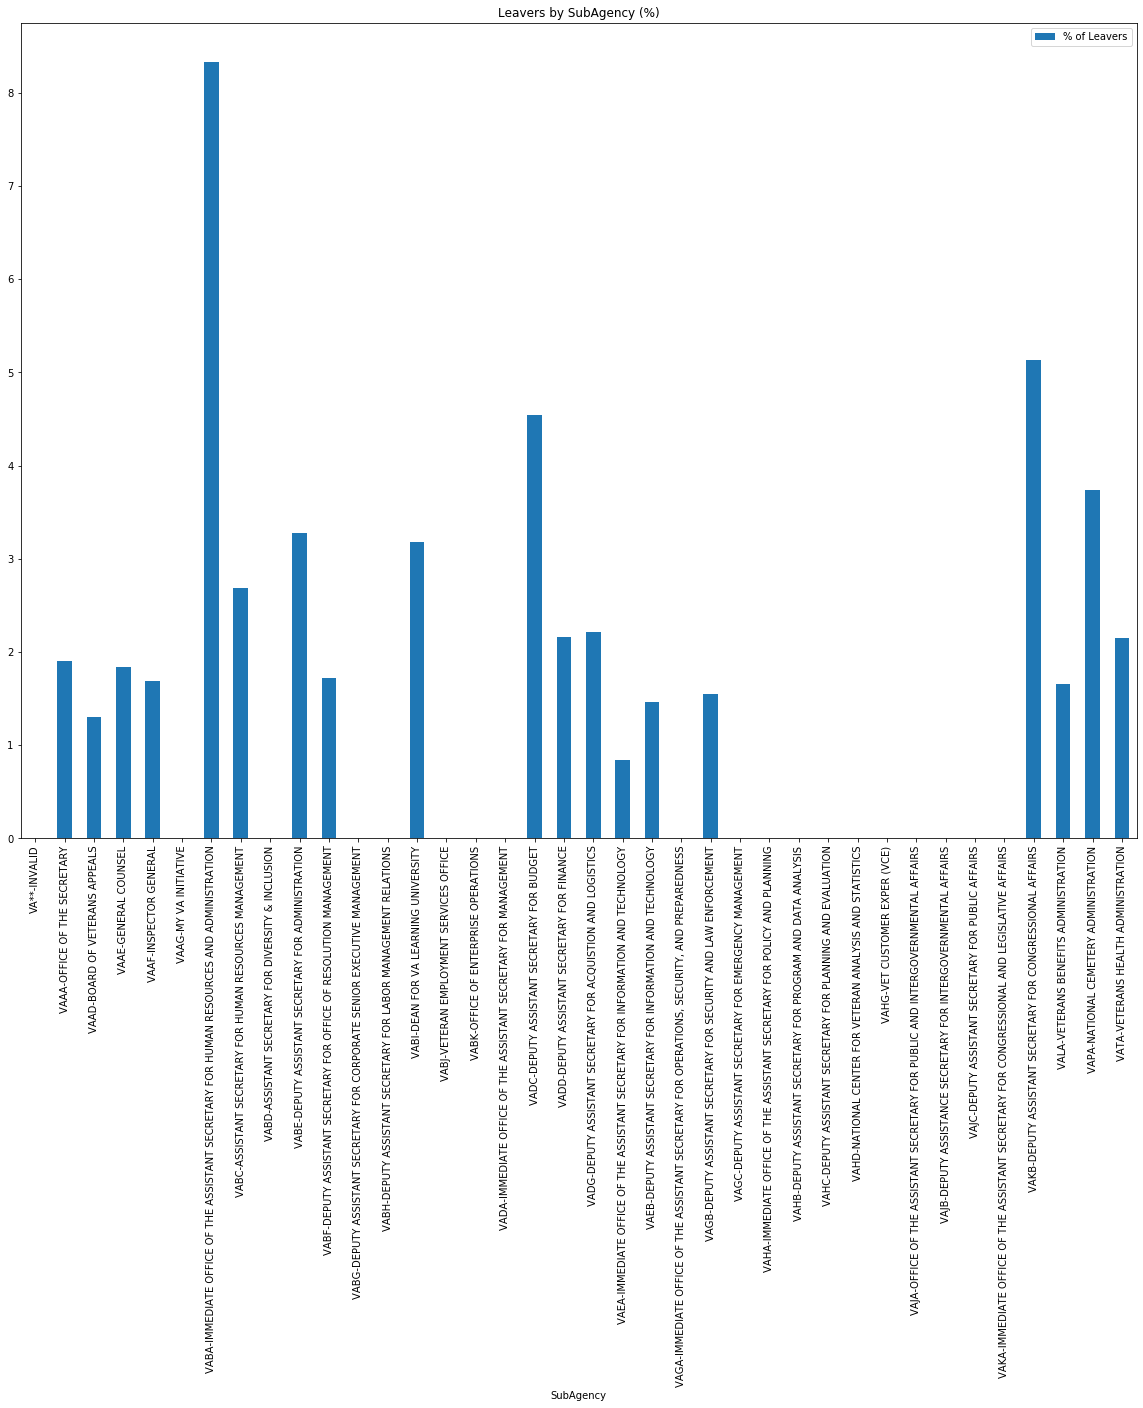

In [31]:
VA_SubAgency = pd.DataFrame(columns=['SubAgency', "% of Leavers"])
i=0
for field in list(VA_employee['SubAgency'].unique()):
    ratio = VA_employee[(VA_employee['SubAgency']==field)&(VA_employee['Attrition']=="Yes")].shape[0] / VA_employee[VA_employee['SubAgency']==field].shape[0]
    VA_SubAgency.loc[i] = (field, ratio*100)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_SA = VA_SubAgency.groupby(by="SubAgency").sum()
df_SA.plot(kind='bar',
           figsize = (20,15),
           title='Leavers by SubAgency (%)')

In [32]:
VA_employee['Grade'].astype(str)

0         11
1         13
2         11
3         05
4         11
          ..
238398    06
238399    07
238400    05
238401    05
238402    02
Name: Grade, Length: 238403, dtype: object

In [33]:
VA_employee[VA_employee.Grade == '*']

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
172133,VATA-VETERANS HEALTH ADMINISTRATION,65,GS,*,30 - 34 years,0647-DIAGNOSTIC RADIOLOGIC TECHNOLOGIST,.,No


In [34]:
VA_employee = VA_employee[VA_employee.Grade != '*']

In [35]:
VA_employee['Grade'].astype(int)

0         11
1         13
2         11
3          5
4         11
          ..
238398     6
238399     7
238400     5
238401     5
238402     2
Name: Grade, Length: 238402, dtype: int64

### GS levels range from 1 to 15. The highest percent of attrition are primarily entry level positions (1, 2, 3, 4)

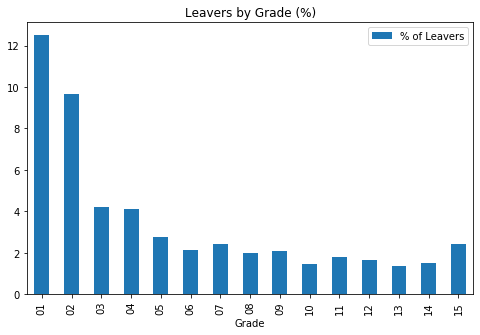

In [36]:
VA_Grade = pd.DataFrame(columns=['Grade', '% of Leavers'])
i=0
for field in list(VA_employee['Grade'].unique()):
    ratio = VA_employee[(VA_employee['Grade']==field)&(VA_employee['Attrition']=="Yes")].shape[0] / VA_employee[VA_employee['Grade']==field].shape[0]
    VA_Grade.loc[i] = (field, ratio*100)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_SA = VA_Grade.groupby(by='Grade').sum()
df_SA.plot(kind='bar',
           figsize =(8,5),
           title='Leavers by Grade (%)')

### Length of service ranges from "Less than 1 year" to "35 or more"   
### These will be put in ranges (similar to AgeRange)  
### Length of service for ex-employees comes out to 8.29 years while current employees show 10.42 years

In [37]:
VA_employee['LengthofService'].value_counts()

5 - 9 years         64866
1 - 2 years         33221
10 - 14 years       31123
3 - 4 years         26425
Less than 1 year    20871
15 - 19 years       19876
25 - 29 years       15357
20 - 24 years       12846
30 - 34 years        8460
35 or more           5357
Name: LengthofService, dtype: int64

In [38]:
VA_employee['LengthofService'] = VA_employee['LengthofService'].map({'Less than 1 year': 0.5, '1 - 2 years': 1.5, 
                                                                     '3 - 4 years': 3.5, '5 - 9 years':7, '10 - 14 years':12,
                                                                     '15 - 19 years':17, '20 - 24 years':22, 
                                                                     '25 - 29 years':27, '30 - 34 years':32, 
                                                                     '35 or more':35})

In [39]:
VA_employee['LengthofService'].astype(str)

0         12.0
1          3.5
2          3.5
3          7.0
4          7.0
          ... 
238398     3.5
238399     3.5
238400     0.5
238401     0.5
238402     0.5
Name: LengthofService, Length: 238402, dtype: object

In [40]:
VA_employee['LengthofService'].astype(int)

0         12
1          3
2          3
3          7
4          7
          ..
238398     3
238399     3
238400     0
238401     0
238402     0
Name: LengthofService, Length: 238402, dtype: int64

In [41]:
print('Average Number of Years at the company for currently active employees: {:.2f} years and ex-employees: {:.2f} years'.format(
    VA_employee[VA_employee['Attrition'] == 'No']['LengthofService'].mean(), VA_employee[VA_employee['Attrition'] == 'Yes']['LengthofService'].mean()))

Average Number of Years at the company for currently active employees: 10.42 years and ex-employees: 8.29 years


### There are 234 unique job titles. 
### 0679 - Medical Support Assistance and 0303 - Miscellaneous Clerk and Program jobs showed the highest attrition rates

In [42]:
VA_employee['Occupation'].nunique()

234

In [43]:
VA_employee['Occupation'].astype(str)

0         1801-GENERAL INSPECTION, INVESTIGATION, ENFORC...
1             0301-MISCELLANEOUS ADMINISTRATION AND PROGRAM
2                                       0101-SOCIAL SCIENCE
3                    0303-MISCELLANEOUS CLERK AND ASSISTANT
4                                       0101-SOCIAL SCIENCE
                                ...                        
238398               0503-FINANCIAL CLERICAL AND ASSISTANCE
238399                           0525-ACCOUNTING TECHNICIAN
238400                               0621-NURSING ASSISTANT
238401                                       0318-SECRETARY
238402                       0640-HEALTH AID AND TECHNICIAN
Name: Occupation, Length: 238402, dtype: object

In [44]:
VA_employee['Occupation'].value_counts().nlargest(10) 

0679-MEDICAL SUPPORT ASSISTANCE                  21684
0620-PRACTICAL NURSE                             15307
0185-SOCIAL WORK                                 13891
0621-NURSING ASSISTANT                           12768
0996-VETERANS CLAIMS EXAMINING                   12218
0303-MISCELLANEOUS CLERK AND ASSISTANT           10884
0660-PHARMACIST                                   8532
0640-HEALTH AID AND TECHNICIAN                    7828
0301-MISCELLANEOUS ADMINISTRATION AND PROGRAM     7499
2210-INFORMATION TECHNOLOGY MANAGEMENT            6942
Name: Occupation, dtype: int64

In [45]:
VA_employee[VA_employee.Occupation == '*-In']

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition


In [46]:
VA_employee = VA_employee.drop(index=3252)

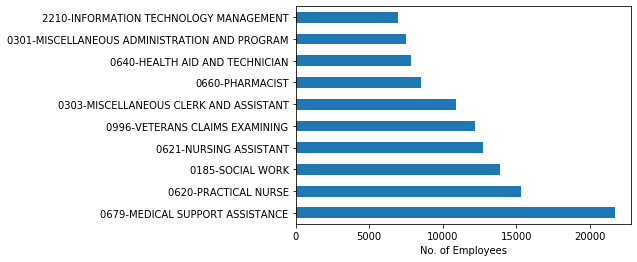

In [47]:
top_occ = VA_employee.Occupation.value_counts()
top_occ[:10].plot(kind='barh')
plt.xlabel('No. of Employees');

In [48]:
VA_employee['Occupation'] = VA_employee['Occupation'].str[:4]

In [49]:
VA_employee.head()

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
0,VALA-VETERANS BENEFITS ADMINISTRATION,55,GS,11,12.0,1801,73510.00,Yes
1,VATA-VETERANS HEALTH ADMINISTRATION,30,GS,13,3.5,0301,92145.00,Yes
2,VATA-VETERANS HEALTH ADMINISTRATION,40,GS,11,3.5,0101,71348.00,Yes
3,VATA-VETERANS HEALTH ADMINISTRATION,50,GS,05,7.0,0303,42012.00,Yes
4,VATA-VETERANS HEALTH ADMINISTRATION,35,GS,11,7.0,0101,.,Yes


In [50]:
s = VA_employee[(VA_employee.Occupation == '0679') | (VA_employee.Occupation == '0620') | (VA_employee.Occupation == '0185') | (VA_employee.Occupation == '0996') | (VA_employee.Occupation == '0621') | (VA_employee.Occupation == '0303') | (VA_employee.Occupation == '0640') | (VA_employee.Occupation == '0660') | (VA_employee.Occupation == '0301') | (VA_employee.Occupation == '2210')]
s.head()

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
1,VATA-VETERANS HEALTH ADMINISTRATION,30,GS,13,3.5,0301,92145.00,Yes
3,VATA-VETERANS HEALTH ADMINISTRATION,50,GS,05,7.0,0303,42012.00,Yes
5,VATA-VETERANS HEALTH ADMINISTRATION,25,GS,05,0.5,0679,32318.00,Yes
6,VATA-VETERANS HEALTH ADMINISTRATION,25,GS,05,0.5,0679,32318.00,Yes
7,VATA-VETERANS HEALTH ADMINISTRATION,25,GS,05,0.5,0679,32318.00,Yes


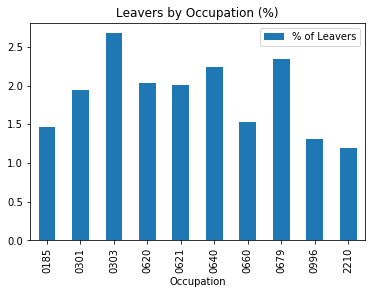

In [51]:
VA_Occupation = pd.DataFrame(columns=['Occupation', '% of Leavers'])
i=0
for field in list(s['Occupation'].unique()):
    ratio = s[(s['Occupation']==field)&(s['Attrition']=="Yes")].shape[0] / s[s['Occupation']==field].shape[0]
    VA_Occupation.loc[i] = (field, ratio*100)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_OC = VA_Occupation.groupby(by='Occupation').sum()
df_OC.plot(kind='bar',title='Leavers by Occupation (%)', )

### Salary ranges from 20527 to 196375.

In [52]:
VA_employee['AdjustedBasicPay']

0         73510.00
1         92145.00
2         71348.00
3         42012.00
4                .
            ...   
238398    41931.00
238399    42702.00
238400    50193.00
238401    32318.00
238402    25733.00
Name: AdjustedBasicPay, Length: 238401, dtype: object

In [53]:
print(VA_employee[VA_employee['AdjustedBasicPay'].isnull()])

Empty DataFrame
Columns: [SubAgency, AgeRange, PayPlan, Grade, LengthofService, Occupation, AdjustedBasicPay, Attrition]
Index: []


In [54]:
VA_employee['AdjustedBasicPay'] = pd.to_numeric(VA_employee['AdjustedBasicPay'], errors='coerce')

In [55]:
VA_employee = VA_employee.dropna(subset=['AdjustedBasicPay'])

In [56]:
VA_employee['AdjustedBasicPay'] = VA_employee['AdjustedBasicPay'].astype(int)

In [57]:
print("Employee Salary Rate varies from ${} to ${}.".format(
    VA_employee['AdjustedBasicPay'].min(), VA_employee['AdjustedBasicPay'].max()))

Employee Salary Rate varies from $20975 to $199175.


In [58]:
#import module
from sklearn.cluster import KMeans
# Filter data
left_emp =  VA_employee[['Grade', 'AdjustedBasicPay']][VA_employee.Attrition == 'Yes']
# Create groups using K-means clustering.
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(left_emp)

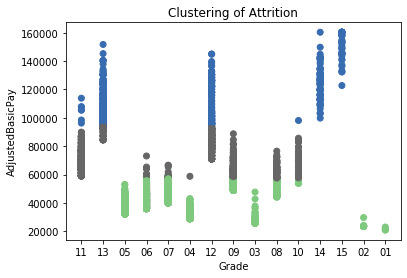

In [59]:
# Add new column "label" annd assign cluster labels.
left_emp['label'] = kmeans.labels_
# Draw scatter plot
plt.scatter(left_emp['Grade'], left_emp['AdjustedBasicPay'], c=left_emp['label'],cmap='Accent')
plt.xlabel('Grade')
plt.ylabel('AdjustedBasicPay')
plt.title('Clustering of Attrition')
plt.show()

## 3. Pre-Processing Pipeline
### Create a Machine Learning Model using Classification (+Gradient Boosting)

In [55]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()

In [56]:
print(VA_employee.shape)
VA_employee.head()

(237948, 8)


,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
0,VALA-VETERANS BENEFITS ADMINISTRATION,55,GS,11,12.0,1801,73510,Yes
1,VATA-VETERANS HEALTH ADMINISTRATION,30,GS,13,3.5,0301,92145,Yes
2,VATA-VETERANS HEALTH ADMINISTRATION,40,GS,11,3.5,0101,71348,Yes
3,VATA-VETERANS HEALTH ADMINISTRATION,50,GS,05,7.0,0303,42012,Yes
5,VATA-VETERANS HEALTH ADMINISTRATION,25,GS,05,0.5,0679,32318,Yes


In [57]:
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in VA_employee.columns[1:]:
    if VA_employee[col].dtype == 'object':
        if len(list(VA_employee[col].unique())) <= 2:
            le.fit(VA_employee[col])
            VA_employee[col] = le.transform(VA_employee[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

2 columns were label encoded.


### Split data into training and testing sets

In [58]:
VA_employee.head()

,SubAgency,AgeRange,PayPlan,Grade,LengthofService,Occupation,AdjustedBasicPay,Attrition
0,VALA-VETERANS BENEFITS ADMINISTRATION,55,0,11,12.0,1801,73510,1
1,VATA-VETERANS HEALTH ADMINISTRATION,30,0,13,3.5,0301,92145,1
2,VATA-VETERANS HEALTH ADMINISTRATION,40,0,11,3.5,0101,71348,1
3,VATA-VETERANS HEALTH ADMINISTRATION,50,0,05,7.0,0303,42012,1
5,VATA-VETERANS HEALTH ADMINISTRATION,25,0,05,0.5,0679,32318,1


In [59]:
X = VA_employee[['AgeRange', 'Grade', 'LengthofService', 'Occupation', 'AdjustedBasicPay']]
y = VA_employee['Attrition']

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

### Evaluate Model Performance

In [71]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))

Accuracy: 0.9800518316172866
Precision: 0.5
Recall: 0.002106741573033708


### Random Forest Classifier

In [93]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

#### The accuracy on the training data is 98.8%

In [94]:
forest.score(X_train, y_train)

0.9885328674435498

#### The model correctly identified 50% of the employees that left. Which was the same exact number as Gradiant Boosting Classifier

In [96]:
# Show Confusion Matrix and Accuracy for the model on test data
# Classification accuracy is a ratio of correct predictions to total predicitions
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, forest.predict(X_test))
TN = conf_matrix[0][1]
TP = conf_matrix[0][1]
FN = conf_matrix[0][1]
FP = conf_matrix[0][1]

print(conf_matrix)
print('Model Testing Accuracy = "{}"'.format(  (TP + TN) / (TP + TN + FN + FP)))

[[69570   391]
 [ 1383    41]]
Model Testing Accuracy = "0.5"


## 4. Conclusion

### As the model does not provide definitive evidence on employee turnover, additional variables should be included to train this model. Examples could be subjective components of the Federal Employee Viewpoint Survey (Employee Engagement Index, Inclusion Quotient Index, Global Satisfaction Index, Belief in Action Index, and the Effective Communication Index) as well as objective (Agency/SubAgency budget and employee ratings - if possible). 
### This was an exploratory analysis into employee turnover inside a Federal Agency. As an initial analysis, we have shown that it is possible to construct a Machine Learning Model to predict turnover. However, due to the infancy of this type of analysis, further examination is needed to improve the model's accuracy, precision, and recall. 